# data mode

In [10]:
import h5py
import torch, numpy as np, matplotlib.pyplot as plt
from src.TorchSimulation.receiver import BER
from src.TorchDSP.loss import Qsq
from src.TorchSimulation.utils import show_symb

def get_grp(f, Nch, Rs, Pch, Nsymb, NF, SF, L=2000, tag=',method=frequency cut'):
    for key in f.keys():
        if f[key].attrs['Nch'] == Nch and f[key].attrs['Rs(GHz)'] == Rs and f[key].attrs['Pch(dBm)'] == Pch and f[key]['SymbTx'].shape[1] == Nsymb and f[key].attrs['NF(dB)'] == NF and f[key].attrs['freqspace(Hz)']/1e9 / f[key].attrs['Rs(GHz)'] == SF and f[key].attrs['distance(km)'] == L:
            return f[key][f'Rx(sps=2,chid=0{tag})']
        
def get_signal(f, Nch, Rs, Pch, Nsymb, NF, SF, L=2000):
    for key in f.keys():
        if f[key].attrs['Nch'] == Nch and f[key].attrs['Rs(GHz)'] == Rs and f[key].attrs['Pch(dBm)'] == Pch and f[key]['SymbTx'].shape[1] == Nsymb and f[key].attrs['NF(dB)'] == NF and f[key].attrs['freqspace(Hz)']/1e9 / f[key].attrs['Rs(GHz)'] == SF and f[key].attrs['distance(km)'] == L:
            return f[key]
        

def Q_list(Rx, Tx, Ntest=10000):
    Q = []
    for t in  np.arange(0, Rx.shape[-2], 10000):
        Q.append(np.mean(BER(torch.from_numpy(Rx[t:t+Ntest]), torch.from_numpy(Tx[t:t+Ntest]))['Qsq']))
    return Q

with h5py.File('dataset_A800/train.h5', 'r') as f:
    for key in f.keys():
        if f[key].attrs['Rs(GHz)'] == 160 and f[key].attrs['Nmodes'] == 1:
            print(key)
        # print('Nch, Rs, Pch, symbs, NF, SF, L:', f[key].attrs['Nch'], f[key].attrs['Rs(GHz)'], f[key].attrs['Pch(dBm)'], f[key]['SymbTx'].shape[1], f[key].attrs['NF(dB)'], f[key].attrs['freqspace(Hz)']/1e9 / f[key].attrs['Rs(GHz)'], f[key].attrs['distance(km)'])

Nmodes1_Rs160_Nch11_Pch-1_unknown
Nmodes1_Rs160_Nch11_Pch-2_unknown
Nmodes1_Rs160_Nch11_Pch-3_unknown
Nmodes1_Rs160_Nch11_Pch-4_unknown
Nmodes1_Rs160_Nch11_Pch-5_unknown
Nmodes1_Rs160_Nch11_Pch-6_unknown
Nmodes1_Rs160_Nch11_Pch-7_unknown
Nmodes1_Rs160_Nch11_Pch-8_unknown
Nmodes1_Rs160_Nch11_Pch0_unknown
Nmodes1_Rs160_Nch11_Pch1_unknown
Nmodes1_Rs160_Nch11_Pch2_unknown
Nmodes1_Rs160_Nch11_Pch3_unknown
Nmodes1_Rs160_Nch11_Pch4_unknown
Nmodes1_Rs160_Nch11_Pch5_unknown
Nmodes1_Rs160_Nch11_Pch6_unknown
Nmodes1_Rs160_Nch1_Pch-1_unknown
Nmodes1_Rs160_Nch1_Pch-2_unknown
Nmodes1_Rs160_Nch1_Pch-3_unknown
Nmodes1_Rs160_Nch1_Pch-4_unknown
Nmodes1_Rs160_Nch1_Pch-5_unknown
Nmodes1_Rs160_Nch1_Pch-6_unknown
Nmodes1_Rs160_Nch1_Pch-7_unknown
Nmodes1_Rs160_Nch1_Pch-8_unknown
Nmodes1_Rs160_Nch1_Pch0_unknown
Nmodes1_Rs160_Nch1_Pch1_unknown
Nmodes1_Rs160_Nch1_Pch2_unknown
Nmodes1_Rs160_Nch1_Pch3_unknown
Nmodes1_Rs160_Nch1_Pch4_unknown
Nmodes1_Rs160_Nch1_Pch5_unknown
Nmodes1_Rs160_Nch1_Pch6_unknown
Nmodes1_R

# plot Q (CDC, DBP)

In [2]:
import os, time, torch, numpy as np, matplotlib.pyplot as plt
from src.TorchDSP.dataloader import MyDataset 
from src.TorchSimulation.receiver import BER
import pandas as pd
import seaborn as sns



def QP(Pch, Rs, Nch, Nmodes, method='CDC'):
    '''
    method: 'CDC' or 'DBP1', 'DBP2', ..., 'DBP32'
    '''
    Q = []
    for pch in Pch:
        test_data = MyDataset('dataset_A800/test.h5', Nch=[Nch], Rs=[Rs], Pch=[pch], Nmodes=Nmodes,
                            window_size=60000, strides=1, Nwindow=1, truncate=20000, 
                            Tx_window=True, pre_transform=f'Rx_{method}DDLMS(taps=32,lr=[0.015625, 0.0078125])')

        # get first batch
        batch = next(iter(test_data))

        Q.append(BER(batch[0], batch[1])['Qsq'])
    return Q

def get_table(method):
    baselines = []
    for rs in [40, 80, 160]:
        for nch in [1, 3, 5, 7, 9, 11]:
            for pch in range(-8, 7):
                Qsq = QP([pch], rs, nch, 1, method)[0].item()
                baselines.append({'Rs': rs, 'Nch': nch, 'Pch': pch, 'Qsq': Qsq})
    
    # 将结果转换为 DataFrame
    df = pd.DataFrame(baselines)
    # 找到每个 Rs 和 Nch 组合的最佳 Qsq 值
    best_results = df.loc[df.groupby(['Rs', 'Nch'])['Qsq'].idxmax()]

    # 创建透视表用于热力图
    pivot_table = best_results.pivot_table(index='Rs', columns='Nch', values='Qsq')

    return pivot_table


## Q-table

In [3]:
cdc = get_table('CDC')

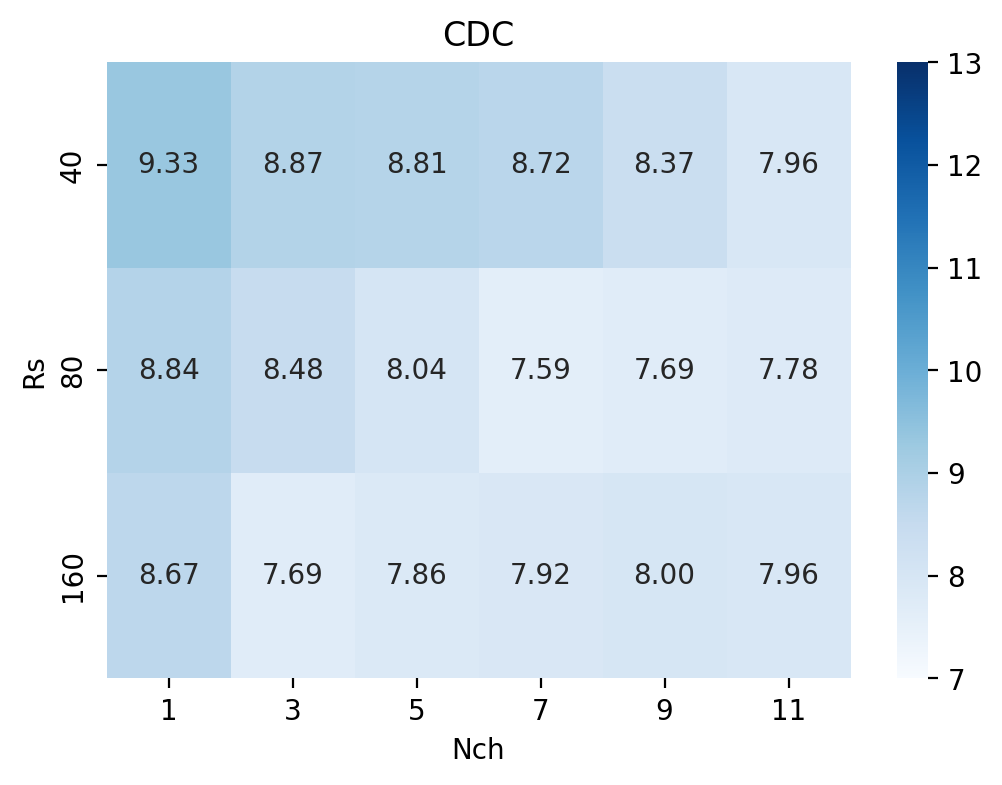

In [4]:
plt.figure(figsize=(6,4), dpi=200)
sns.heatmap(cdc, annot=True, cmap='Blues', fmt=".2f", vmin=7, vmax=13)
plt.title('CDC')
plt.xlabel('Nch')
plt.ylabel('Rs')
plt.show()

## Q-curve

In [5]:
Q = {}
for method in ['CDC','DBP1', 'DBP2', 'DBP4', 'DBP8', 'DBP16', 'DBP32']:
    Q[method] = QP(range(-8, 7), 40, 11, 1, method=method)

(4.0, 11.0)

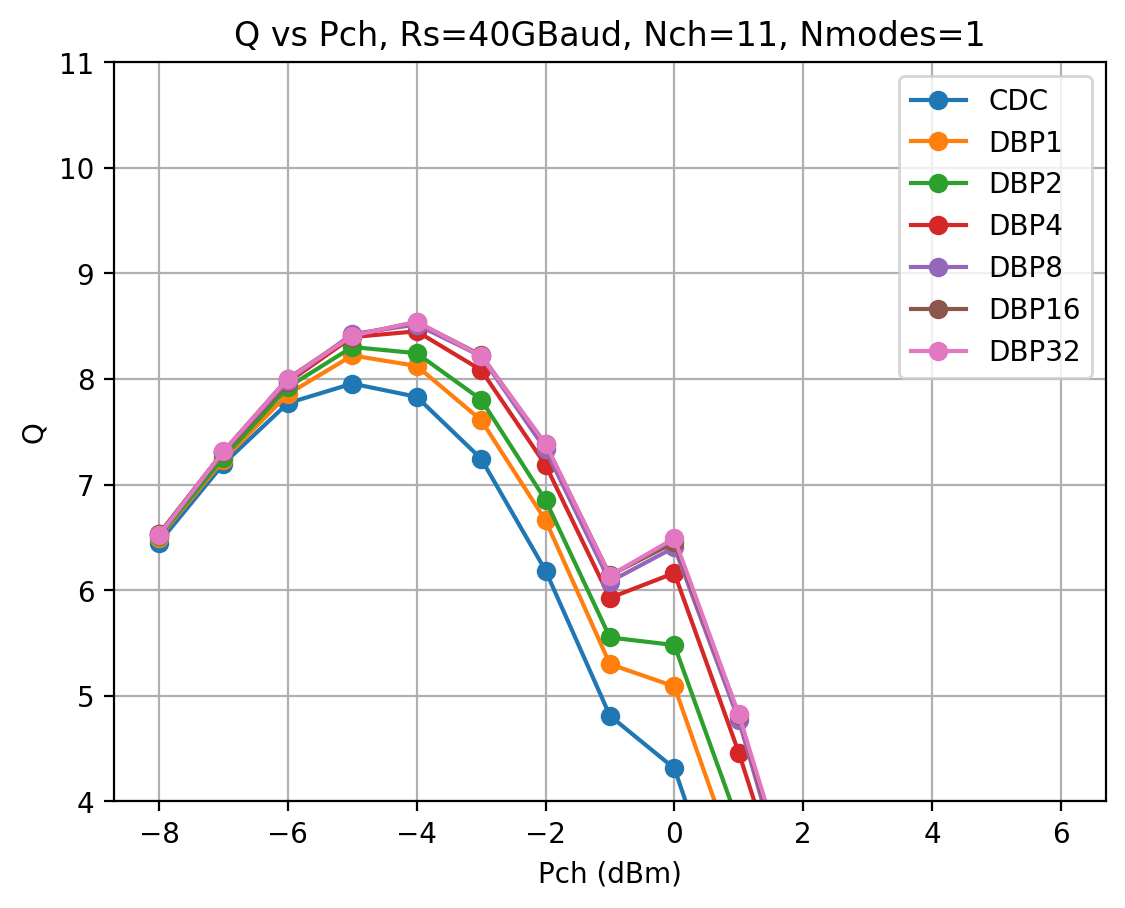

In [6]:
plt.figure(dpi=200)
for key in Q.keys():
    plt.plot(range(-8, 7), Q[key], '-o', label=key)
plt.legend()
plt.title('Q vs Pch, Rs=40GBaud, Nch=11, Nmodes=1')
plt.xlabel('Pch (dBm)')
plt.ylabel('Q')
plt.grid()
plt.ylim(4, 11)

In [16]:
print('Nch=11, Rs=80G, Nmodes=1, CDC:', np.max(Q['CDC']))

Nch=11, Rs=80G, Nmodes=1, CDC: 7.7790637


In [13]:
print('Nch=11, Rs=160G, Nmodes=1, CDC:', np.max(Q['CDC']))

Nch=11, Rs=160G, Nmodes=1, CDC: 7.960717


# plot N-filter

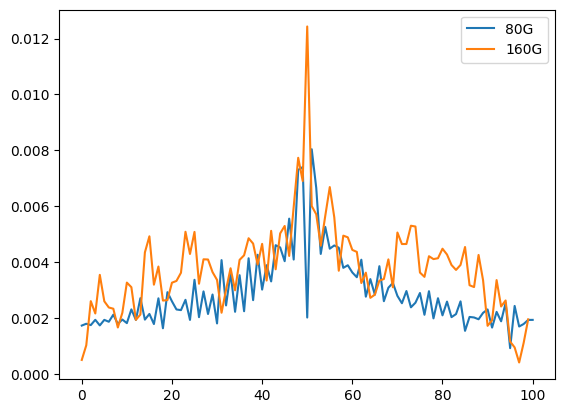

In [214]:
import torch, numpy as np, matplotlib.pyplot as plt
from src.TorchDSP.dsp import TestDBP

dic = torch.load('_models/train_dbp/test_steps5_ntaps401/30.pth', map_location='cpu')
model = TestDBP(**dic['dbp_info'])
model.load_state_dict(dic['dbp_param'])
k1 = model.Nkernel[0][0,0].data
plt.plot(k1[150:251], label='80G')

dic = torch.load('_models/train_dbp/test_160G_steps5_ntaps401_Dfix/30.pth', map_location='cpu')
model = TestDBP(**dic['dbp_info'])
model.load_state_dict(dic['dbp_param'])
k2 = model.Nkernel[0][0,0].data
plt.plot(4*k2[1::4], label='160G')
plt.legend()

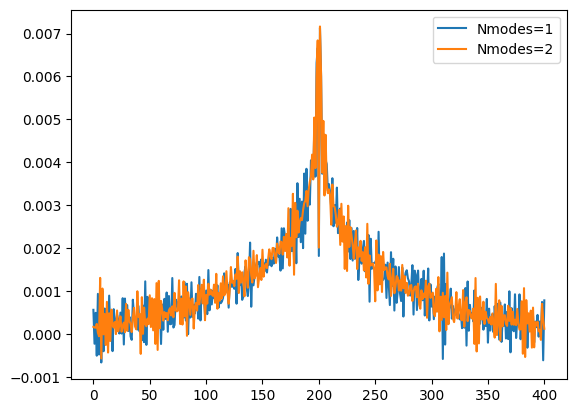

In [203]:
import torch, numpy as np, matplotlib.pyplot as plt
from src.TorchDSP.dsp import TestDBP

dic = torch.load('_models/train_dbp/test_steps5_ntaps401/10.pth', map_location='cpu')
model = TestDBP(**dic['dbp_info'])
model.load_state_dict(dic['dbp_param'])
k1 = model.Nkernel[0][0,0].data
plt.plot(k1*8/9, label='Nmodes=1')

dic = torch.load('_models/train_dbp/test_steps5_ntaps401_Nmodes2/10.pth', map_location='cpu')
model = TestDBP(**dic['dbp_info'])
model.load_state_dict(dic['dbp_param'])
k2 = model.Nkernel[0][0,0].data
plt.plot(k2, label='Nmodes=2')
plt.legend()

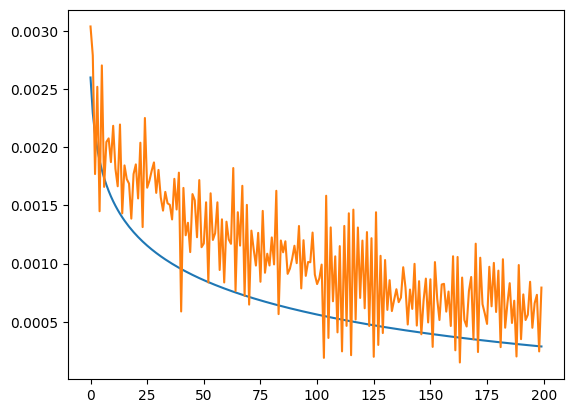

In [202]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special
from src.TorchDSP.dsp import  get_beta2 

dic = torch.load('_models/train_dbp/test_160G_steps8_ntaps401_Dfix/30.pth', map_location='cpu')
model = TestDBP(**dic['dbp_info'])
model.load_state_dict(dic['dbp_param'])
k2 = model.Nkernel[0][0,0].data

num = model.ntaps // 2


beta2 = get_beta2(model.D, model.Fc)  # [s^2/km]
T = 1 / (model.Fs/2)      # [s]   inverse of symbol rate
tau = T / 2               # [s]   pulse width
L = model.dz / 1e3        # [km]
gamma = model.gamma       # [1/W/km]
def C(m):
    return gamma * tau**2/(np.sqrt(3)*np.abs(beta2)) * 1/2 * scipy.special.exp1(m**2 * T**2 * tau**2 / (3*beta2**2*L**2))

plt.plot(C(np.arange(1, num + 1)), label='Nmodes=2')
plt.plot(k2[num+1:], label='trained')

# Q-table

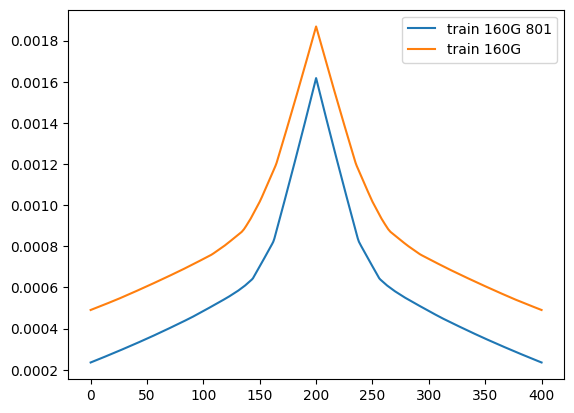

In [1]:
import torch, numpy as np, matplotlib.pyplot as plt
from src.TorchDSP.dsp import TestDBP, LDBP

# dic = torch.load('_models/train_dbp/test_160G_newdbp_train20G/20.pth')
# model = LDBP(dic['dbp_info'])
# model.load_state_dict(dic['dbp_param'])
# model = model.to('cpu')
# plt.plot(model.get_N_kernel(torch.tensor([[1, 0, 320e9, 1]])).squeeze().detach().numpy(), label='train 20G')


# dic = torch.load('_models/train_dbp/test_160G_newdbp_train40G/20.pth')
# model = LDBP(dic['dbp_info'])
# model.load_state_dict(dic['dbp_param'])
# model = model.to('cpu')
# plt.plot(model.get_N_kernel(torch.tensor([[1, 0, 320e9, 1]])).squeeze().detach().numpy(), label='train 40G')

# dic = torch.load('_models/train_dbp/test_160G_newdbp_train80G/20.pth')
# model = LDBP(dic['dbp_info'])
# model.load_state_dict(dic['dbp_param'])
# model = model.to('cpu')
# plt.plot(model.get_N_kernel(torch.tensor([[1, 0, 320e9, 1]])).squeeze().detach().numpy(), label='train 80G')

dic = torch.load('_models/train_dbp/test_160G_newdbp_train160G_ntaps801/20.pth')
model = LDBP(dic['dbp_info'])
model.load_state_dict(dic['dbp_param'])
model = model.to('cpu')
plt.plot(model.get_N_kernel(torch.tensor([[1, 0, 320e9, 1]])).squeeze().detach().numpy()[200:601], label='train 160G 801')

dic = torch.load('_models/train_dbp/test_160G_newdbp_train160G/20.pth')
model = LDBP(dic['dbp_info'])
model.load_state_dict(dic['dbp_param'])
model = model.to('cpu')
plt.plot(model.get_N_kernel(torch.tensor([[1, 0, 320e9, 1]])).squeeze().detach().numpy(), label='train 160G')

plt.legend()

# plot Meta-DSP

Import Time: 2.00s
Nch         1         3         5         7         9         11
Rs                                                              
40   10.790131  9.752254  9.706789  9.281553  8.850621  8.255717
80    9.806803  9.012351  8.528085  8.096881  8.251739  8.322896
160   9.198277  7.947540  8.002587  8.155501  8.218342  8.304276


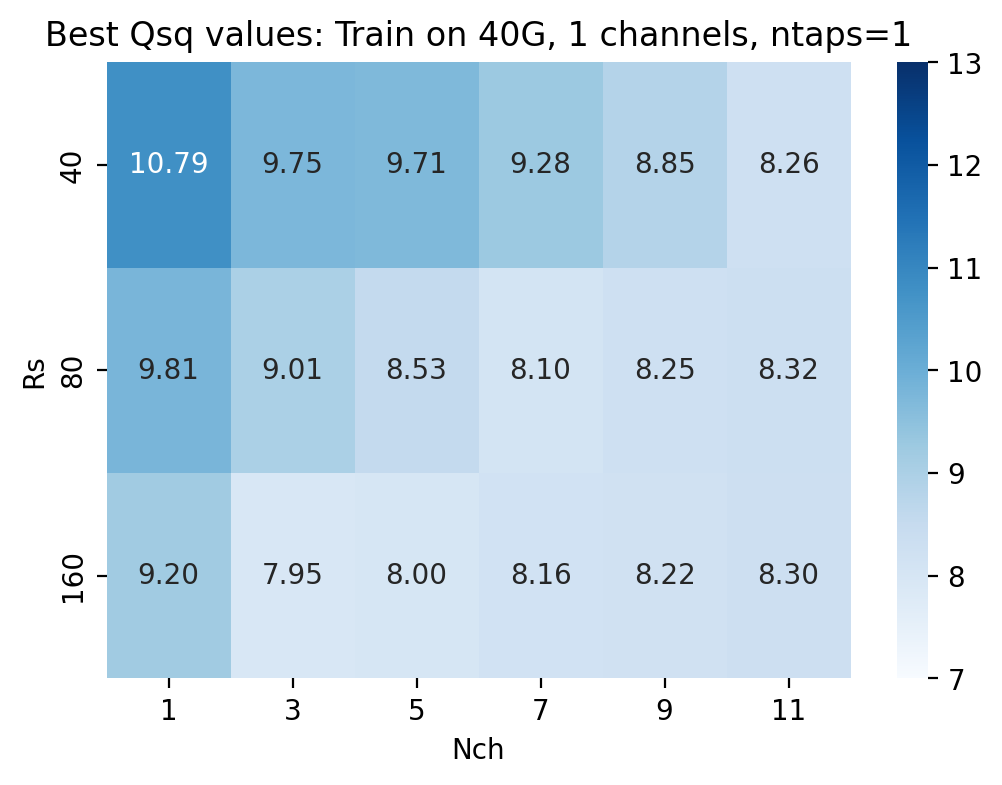

In [8]:
import torch, numpy as np, matplotlib.pyplot as plt
from src.TorchDSP.dsp import TestDBP, LDBP
from src.TorchDSP.train_dbp import Test, Train
from src.TorchDSP.dataloader import  MyDataset

dic = torch.load('_models/train_dbp/test_160G_newdbp_train40G_ntaps201/20.pth')
model = LDBP(dic['dbp_info'])
model.load_state_dict(dic['dbp_param'])
model = model.to('cuda:0')
model.set_ntaps(401)

model.cuda()

# 初始化列表以存储结果
results = []

# 运行测试并记录结果
for rs in [40, 80, 160]:
    for nch in [1, 3, 5, 7, 9, 11]:
        for pch in range(-8, 7):
            Qsq = Test(model, 'cuda:0', Pch=pch, Nch=nch, Rs=rs, Nmodes=1)['Qsq']
            results.append({'Rs': rs, 'Nch': nch, 'Pch': pch, 'Qsq': Qsq})

import pandas as pd
import seaborn as sns
df = pd.DataFrame(results)
best_results = df.loc[df.groupby(['Rs', 'Nch'])['Qsq'].idxmax()]
pivot_table = best_results.pivot_table(index='Rs', columns='Nch', values='Qsq')
print(pivot_table)

# 绘制热力图
plt.figure(figsize=(6,4), dpi=200)
sns.heatmap(pivot_table, annot=True, cmap='Blues', fmt=".2f", vmin=7, vmax=13)
plt.title('Best Qsq values: Train on 40G, 1 channels, ntaps=1')
plt.xlabel('Nch')
plt.ylabel('Rs')
plt.show()

In [46]:
df[df['Rs']==160][df['Nch'] == 11]

/tmp/ipykernel_81752/2171137877.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['Rs']==160][df['Nch'] == 11]


,Rs,Nch,Pch,Qsq
255,160,11,-8,1.311524
256,160,11,-7,2.313699
257,160,11,-6,3.094392
258,160,11,-5,3.925888
259,160,11,-4,4.744941
260,160,11,-3,5.641924
261,160,11,-2,6.437914
262,160,11,-1,7.029444
263,160,11,0,7.783526
264,160,11,1,8.269720


In [ ]:
Q_ntaps = []
ntaps_ = [1, 5, 11, 21, 41, 81, 101, 201, 401, 801]
Pch = -2
Nch = 1
Rs = 40
for ntaps in ntaps_:
    model.set_ntaps(ntaps)
    Q_ntaps.append(Test(model, 'cuda:0', Pch=Pch, Nch=Nch, Rs=Rs, Nmodes=1)['Qsq'])




plt.figure(dpi=200)
plt.plot(ntaps_, Q_ntaps, '-o')

i = np.argmax(Q_ntaps)
plt.text(ntaps_[i], Q_ntaps[i], 'Q max: %.2f' % Q_ntaps[i])

plt.xlabel('ntaps')
plt.ylabel('Qsq')
plt.grid()
plt.title(f'Qsq vs ntaps, Rs={Rs}G, Nch={Nch}, Pch={Pch} (best pch), Nmodes=1')

# increase ntaps while tesing

In [31]:
import torch, numpy as np, matplotlib.pyplot as plt
from src.TorchDSP.dsp import TestDBP, LDBP

dic = torch.load('_models/train_dbp/test_160G_train160G_FDBP/20.pth', map_location='cpu')
model = LDBP(dic['dbp_info'])
model.load_state_dict(dic['dbp_param'])
model = model.to('cuda:0')

In [32]:
Test(model, 'cuda:0', Pch=1, Nch=11, Rs=160, Nmodes=1)['Qsq']

8.310456982310821

In [30]:
from src.TorchDSP.train_dbp import Test
model.set_ntaps(801)
model = model.to('cuda:0')
Test(model, 'cuda:0', Pch=1, Nch=11, Rs=160, Nmodes=1)['Qsq']

8.329154276142335

In [1]:
import torch, numpy as np, matplotlib.pyplot as plt
from src.TorchDSP.dsp import TestDBP, LDBP

dic = torch.load('_models/train_dbp/test_160G_newdbp_train160G_ntaps1601/20.pth', map_location='cpu')
model = LDBP(dic['dbp_info'])
model.load_state_dict(dic['dbp_param'])
model = model.to('cuda:0')

In [2]:
from src.TorchDSP.train_dbp import Test
model.set_ntaps(401)
model = model.to('cuda:0')
Test(model, 'cuda:0', Pch=1, Nch=11, Rs=160, Nmodes=1)['Qsq']

Import Time: 1.35s


8.294030107429203

Text(0.5, 1.0, 'N-filter')

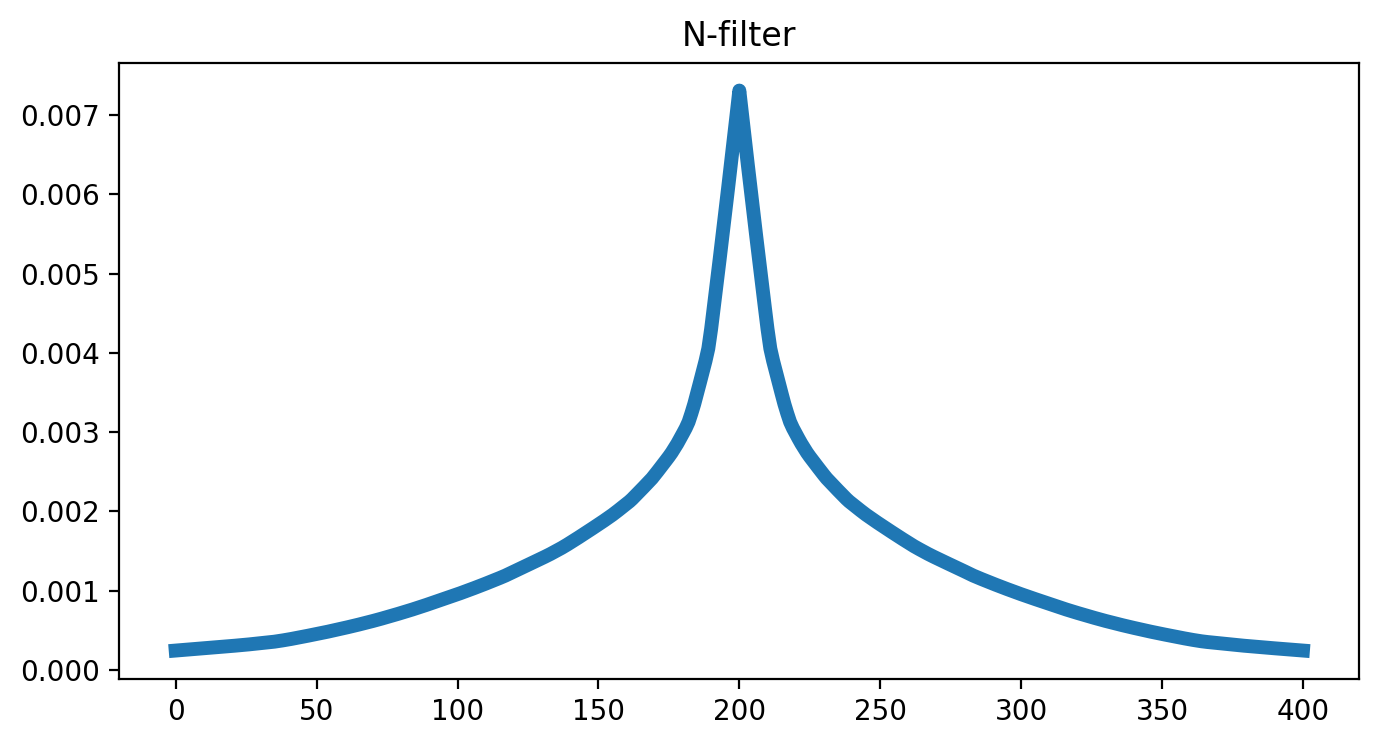

In [20]:
model = model.to('cpu')
plt.figure(dpi=200, figsize=(8,4))
plt.plot(model.get_N_kernel(torch.tensor([[1, 0, 160e9, 1]])).squeeze().detach().numpy(), linewidth=5, label='train 20G')
plt.title('N-filter')

# plot FDBP table

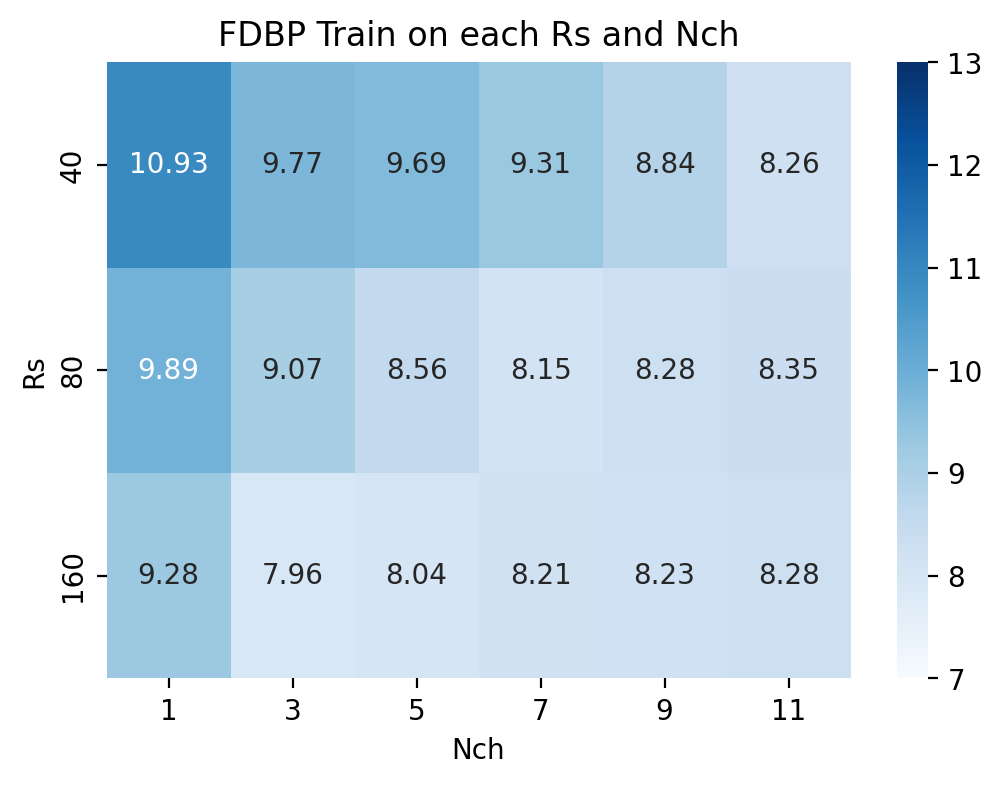

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 创建数据
data = {
    'Rs': [40, 40, 40, 40, 40, 40, 80, 80, 80, 80, 80, 80, 160, 160, 160, 160, 160, 160],
    'Nch': [1, 3, 5, 7, 9, 11, 1, 3, 5, 7, 9, 11, 1, 3, 5, 7, 9, 11],
    'Qmax': [10.928148599622471, 9.765620797581091, 9.694156607066889, 9.307740123808374, 8.84153607388848, 8.255716590091284,
             9.894574198538153, 9.06882459539538, 8.55958745896146, 8.146197108103623, 8.281826258542877, 8.348088229375513,
             9.277245872809448, 7.960717051974736, 8.040341093853822, 8.214459702993016, 8.228089195494956, 8.283853448594606]
}

# 转换为 DataFrame
df = pd.DataFrame(data)

# 创建透视表
pivot_table_fdbp = df.pivot_table(index='Rs', columns='Nch', values='Qmax')

# 绘制热力图

# 绘制热力图
plt.figure(figsize=(6,4), dpi=200)
sns.heatmap(pivot_table_fdbp, annot=True, cmap='Blues', fmt=".2f", vmin=7, vmax=13)
plt.title('FDBP Train on each Rs and Nch')
plt.xlabel('Nch')
plt.ylabel('Rs')
plt.show()

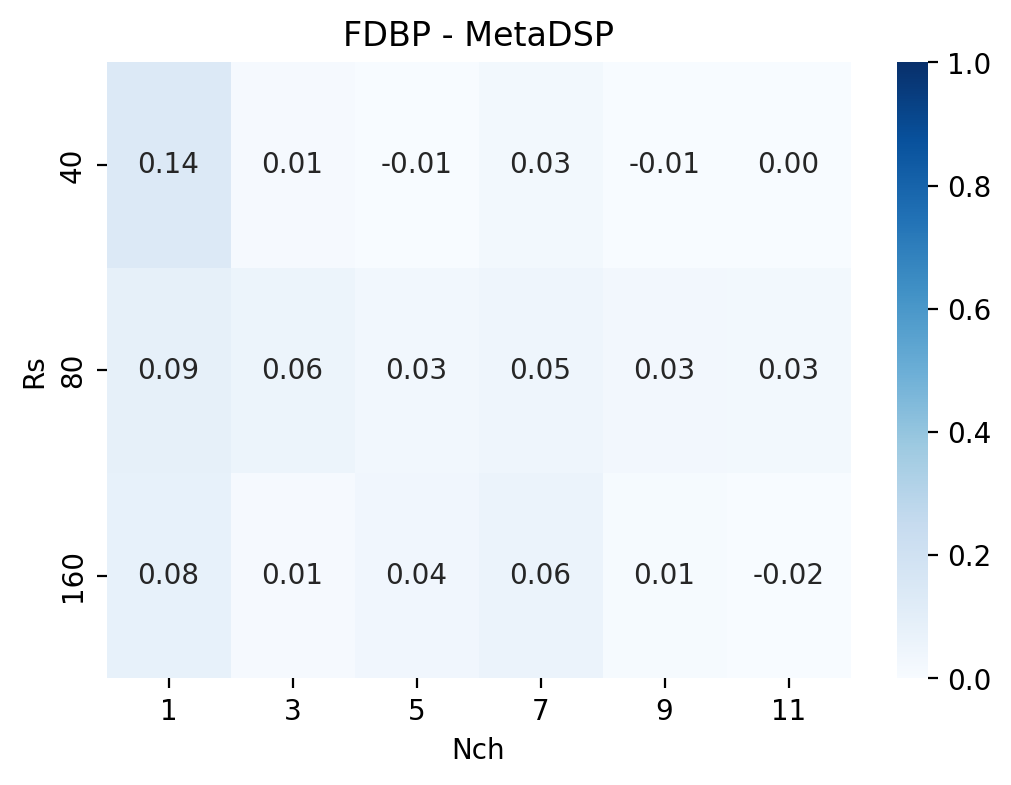

In [19]:
diff = pivot_table_fdbp - pivot_table

plt.figure(figsize=(6,4), dpi=200)
sns.heatmap(diff, annot=True, cmap='Blues', fmt=".2f", vmin=0, vmax=1)
plt.title('FDBP - MetaDSP')
plt.xlabel('Nch')
plt.ylabel('Rs')
plt.show()

## FDBP 交叉验证

In [1]:
import torch, numpy as np, matplotlib.pyplot as plt
from src.TorchDSP.dsp import TestDBP, LDBP
from src.TorchDSP.train_dbp import Test, Train

def get_fdbp(Rs, Nch):
    dic = torch.load(f'_models/train_dbp/train_{Rs}G_{Nch}ch_FDBP/20.pth', map_location='cpu')
    model = LDBP(dic['dbp_info'])
    model.load_state_dict(dic['dbp_param'])
    model = model.to('cuda:0')
    return model

Import Time: 4.68s


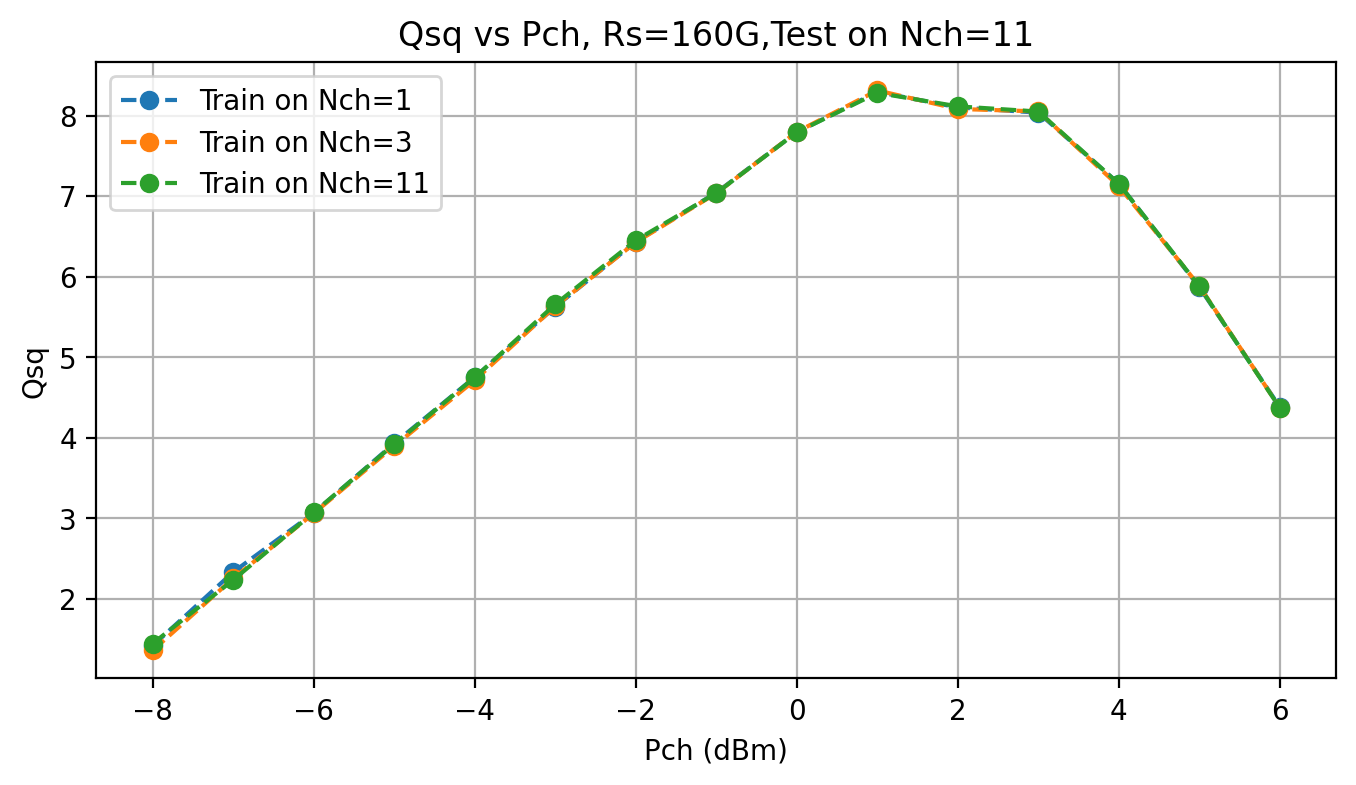

In [2]:
Rs = 160
Nch_ = [1,3,5,7,9,11]

plt.figure(dpi=200, figsize=(8,4))
model = get_fdbp(Rs, 1)
Qs = [Test(model, Pch=pch, Nch=11, Rs=Rs, Nmodes=1)['Qsq'] for pch in range(-8, 7)]
plt.plot(range(-8, 7), Qs, '--o', label='Train on Nch=1')

model = get_fdbp(Rs, 3)
Qs = [Test(model, Pch=pch, Nch=11, Rs=Rs, Nmodes=1)['Qsq'] for pch in range(-8, 7)]
plt.plot(range(-8, 7), Qs, '--o', label='Train on Nch=3')

model = get_fdbp(Rs, 11)
Qs = [Test(model, Pch=pch, Nch=11, Rs=Rs, Nmodes=1)['Qsq'] for pch in range(-8, 7)]
plt.plot(range(-8, 7), Qs, '--o', label='Train on Nch=11')
 
plt.xlabel('Pch (dBm)')
plt.ylabel('Qsq')
plt.title(f'Qsq vs Pch, Rs={Rs}G,Test on Nch=11')
plt.grid()
plt.legend()